In [3]:
import os
import random
import datetime

import cv2
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import v2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class UpSample(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.swish = nn.SELU()

        self.conv1 = nn.Conv2d(in_channels=(in_channels + skip_channels), out_channels=out_channels, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='selu')
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='selu')
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='selu')
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x, x_skip):
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, x_skip], dim=1)
        x = self.bn1(self.swish(self.conv1(x)))
        x = self.bn2(self.swish(self.conv2(x)))
        x = self.bn3(self.swish(self.conv3(x)))
        return x


class Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.swish = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='selu')
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='selu')
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='selu')
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.constant_(self.conv4.bias, 0)

    def forward(self, x):
        x = self.bn1(self.swish(self.conv1(x)))
        x = self.bn2(self.swish(self.conv2(x)))
        x = self.bn3(self.swish(self.conv3(x)))
        x = self.sigmoid(self.conv4(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        children = list(resnet50(weights=ResNet50_Weights.DEFAULT).children())
        self.preprocess = nn.Sequential(*children[:3])
        self.maxpool = children[3]
        
        self.layer1 = children[4]
        self.layer2 = children[5]
        self.layer3 = children[6]
        self.layer4 = children[7]

        self.up5 = UpSample(2048, 1024, 256)
        self.up4 = UpSample(256, 512, 128)
        self.up3 = UpSample(128, 256, 64)
        self.up2 = UpSample(64, 64, 32)
        self.up1 = UpSample(32, 3, 16)

        self.postprocess = Head()

    def forward(self, x):
        
        image = x

        x_skip1 = self.preprocess(x)
        x = self.maxpool(x_skip1)

        x_skip2 = self.layer1(x)
        x_skip3 = self.layer2(x_skip2)
        x_skip4 = self.layer3(x_skip3)
        x = self.layer4(x_skip4)

        x = self.up5(x, x_skip4)
        x = self.up4(x, x_skip3)
        x = self.up3(x, x_skip2)
        x = self.up2(x, x_skip1)
        x = self.up1(x, image)

        x = self.postprocess(x)

        return x

In [50]:
class RoadsDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None, preprocessing=None):
        super().__init__()
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.preprocessing = preprocessing
        self.filenames = list(filter(lambda filename: filename.endswith('tiff'), os.listdir(images_path)))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]

        image = cv2.cvtColor(cv2.imread(f'{self.images_path}/{filename}'), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f'{self.masks_path}/{filename[:-1]}', cv2.IMREAD_GRAYSCALE)
        mask[(image > 250).all(axis=2)] = 0

        if self.transform:
            image, mask = self.transform(image=image, mask=mask).values()

        if self.preprocessing:
            image, mask = self.preprocessing(image=image, mask=mask).values()

        return image, mask[None, ...]

In [44]:
def compute_IoU(mask, pred_mask):
    intersection = torch.logical_and(mask, pred_mask).sum()
    union = torch.logical_or(mask, pred_mask).sum()
    return intersection / union


def compute_differentiable_IoU(mask, pred_mask):
    multiplication = mask * pred_mask
    intersection = multiplication.sum()
    union = (mask + pred_mask - multiplication).sum()
    return intersection / union

In [45]:
def train_loop(model, optimizer, dataloader):
    print('--------------------------- TRAINING START ---------------------------')
    model.train()

    images_num = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_IoU = 0

    start = datetime.datetime.now()
    for i, (images, masks) in enumerate(dataloader):

        pred_masks = model(images.to(device))
        IoU = compute_differentiable_IoU(masks.to(device), pred_masks)
        IoU.backward()
        running_IoU += IoU.item()

        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        if i % 10 == 0:
            current = i * dataloader.batch_size + len(images)
            finish = datetime.datetime.now()
            difference = finish - start
            print(f'IoU: {(IoU.item() * 100):.1f}% [{current}/{images_num} images] [{i + 1}/{num_batches} batches] {difference}')

    print('--------------------------- TRAINING FINISH ---------------------------\n')
    return running_IoU / num_batches

In [46]:
def val_loop(model, dataloader, mode='VALIDATION'):
    print(f'--------------------------- {mode} START ---------------------------')
    model.eval()

    images_num = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_IoU = 0

    start = datetime.datetime.now()
    for i, (images, masks) in enumerate(dataloader):

        with torch.no_grad():
            pred_masks = model(images.to(device))
            IoU = compute_IoU(masks.to(device), torch.where(pred_masks > 0.5, 1, 0))
            running_IoU += IoU.item()
            torch.cuda.empty_cache()

        if i % 2 == 0:
            current = i * dataloader.batch_size + len(images)
            finish = datetime.datetime.now()
            difference = finish - start
            print(f'IoU: {(IoU.item() * 100):.1f}% [{current}/{images_num} images] [{i + 1}/{num_batches} batches] {difference}')

    print(f'--------------------------- {mode} FINISH ---------------------------\n')
    return running_IoU / num_batches

In [47]:
def fit(model, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader, epochs):
    best_IoU = val_loop(model, val_dataloader)
    for epoch in range(epochs):
        print(f'------------------------------------- EPOCH {epoch + 1}-------------------------------------')

        lr = optimizer.param_groups[0]["lr"]

        IoU = train_loop(model, optimizer, train_dataloader)
        print(f'\n~~~ train_IoU = {IoU} ~~~\n')

        IoU = val_loop(model, val_dataloader)
        print(f'\n~~~ val_IoU = {IoU} ~~~\n')

        scheduler.step(IoU)

        if IoU > best_IoU:
            best_IoU = IoU
            torch.save(model, 'best_model.pt')

    model = torch.load('best_model.pt', map_location=device)
    IoU = val_loop(model, test_dataloader, 'TESTING')
    print(f'\n~~~ test_IoU = {IoU} ~~~\n')

In [71]:
train_transformations = A.Compose([A.RandomCrop(256, 256),
                                   A.OneOf([A.HorizontalFlip(p=1),
                                            A.VerticalFlip(p=1),
                                            A.RandomRotate90(p=1)], p=0.75)])

val_transformations = A.PadIfNeeded(1536, 1536, border_mode=0)

preprocessing = A.Compose([lambda image, mask, **kwargs: {'image': (image / 255).astype('float32'), 'mask': (mask / 255).astype('float32')},
                           A.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225]),
                           ToTensorV2()])

In [72]:
dataset_path = 'datasets/MassachusettsRoads/tiff'
train_dataset = RoadsDataset(f'{dataset_path}/images/train',
                             f'{dataset_path}/binary_masks/train',
                             train_transformations, preprocessing)
val_dataset = RoadsDataset(f'{dataset_path}/images/val',
                           f'{dataset_path}/binary_masks/val',
                           val_transformations, preprocessing)
test_dataset = RoadsDataset(f'{dataset_path}/images/test',
                            f'{dataset_path}/binary_masks/test',
                            val_transformations, preprocessing)

In [63]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [12]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1E-4, maximize=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5)
epochs = 150
fit(model, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader, epochs)

--------------------------- VALIDATION START ---------------------------
IoU: 2.0% [1/14 images] [1/14 batches] 0:00:00.633178
IoU: 4.1% [3/14 images] [3/14 batches] 0:00:01.170349
IoU: 4.8% [5/14 images] [5/14 batches] 0:00:01.723079
IoU: 5.8% [7/14 images] [7/14 batches] 0:00:02.255732
IoU: 7.3% [9/14 images] [9/14 batches] 0:00:02.802498
IoU: 1.6% [11/14 images] [11/14 batches] 0:00:03.441154
IoU: 5.4% [13/14 images] [13/14 batches] 0:00:04.003593
--------------------------- VALIDATION FINISH ---------------------------

------------------------------------- EPOCH 1-------------------------------------
--------------------------- TRAINING START ---------------------------
IoU: 4.2% [16/1108 images] [1/70 batches] 0:00:02.505818
IoU: 10.4% [176/1108 images] [11/70 batches] 0:00:19.245026
IoU: 9.7% [336/1108 images] [21/70 batches] 0:00:34.625154
IoU: 8.9% [496/1108 images] [31/70 batches] 0:00:50.127929
IoU: 6.3% [656/1108 images] [41/70 batches] 0:01:05.644378
IoU: 11.2% [816/1108 i

In [31]:
from torchvision.models import resnet101, ResNet101_Weights

In [32]:
class UNet_(nn.Module):
    def __init__(self):
        super().__init__()
        
        children = list(resnet101(weights=ResNet101_Weights.DEFAULT).children())
        self.preprocess = nn.Sequential(*children[:3])
        self.maxpool = children[3]
        
        self.layer1 = children[4]
        self.layer2 = children[5]
        self.layer3 = children[6]
        self.layer4 = children[7]

        self.up5 = UpSample(2048, 1024, 256)
        self.up4 = UpSample(256, 512, 128)
        self.up3 = UpSample(128, 256, 64)
        self.up2 = UpSample(64, 64, 32)
        self.up1 = UpSample(32, 3, 16)

        self.postprocess = Head()

    def forward(self, x):
        
        image = x

        x_skip1 = self.preprocess(x)
        x = self.maxpool(x_skip1)

        x_skip2 = self.layer1(x)
        x_skip3 = self.layer2(x_skip2)
        x_skip4 = self.layer3(x_skip3)
        x = self.layer4(x_skip4)

        x = self.up5(x, x_skip4)
        x = self.up4(x, x_skip3)
        x = self.up3(x, x_skip2)
        x = self.up2(x, x_skip1)
        x = self.up1(x, image)

        x = self.postprocess(x)

        return x

In [15]:
model.cpu()
torch.cuda.empty_cache()

In [ ]:
model_ = UNet_().to(device)
optimizer = torch.optim.Adam(model_.parameters(), lr=1E-4, maximize=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5)
epochs = 200
fit(model_, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader, epochs)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:07<00:00, 25.0MB/s] 


--------------------------- VALIDATION START ---------------------------
IoU: 4.0% [1/14 images] [1/14 batches] 0:00:00.614874
IoU: 6.2% [3/14 images] [3/14 batches] 0:00:01.216061
IoU: 8.4% [5/14 images] [5/14 batches] 0:00:01.801594
IoU: 8.9% [7/14 images] [7/14 batches] 0:00:02.401344
IoU: 9.5% [9/14 images] [9/14 batches] 0:00:02.978077
IoU: 3.1% [11/14 images] [11/14 batches] 0:00:03.551150
IoU: 7.5% [13/14 images] [13/14 batches] 0:00:04.123984
--------------------------- VALIDATION FINISH ---------------------------

------------------------------------- EPOCH 1-------------------------------------
--------------------------- TRAINING START ---------------------------
IoU: 3.6% [16/1108 images] [1/70 batches] 0:00:01.824807
IoU: 8.6% [176/1108 images] [11/70 batches] 0:00:20.219710
IoU: 11.1% [336/1108 images] [21/70 batches] 0:00:38.850524
IoU: 7.8% [496/1108 images] [31/70 batches] 0:00:56.985766
IoU: 11.3% [656/1108 images] [41/70 batches] 0:01:14.872734
IoU: 13.6% [816/1108 

In [73]:
visualize_dataset = RoadsDataset(f'{dataset_path}/images/train',
                                 f'{dataset_path}/binary_masks/train',
                                 train_transformations, 
                                 A.Compose([lambda image, mask, **kwargs: {'image': (image / 255).astype('float32'), 'mask': (mask / 255).astype('float32')}, 
                                            ToTensorV2()]))

In [74]:
def predict(model, images):
    model.eval()
    with torch.no_grad():
        preds = model(images)
    return preds

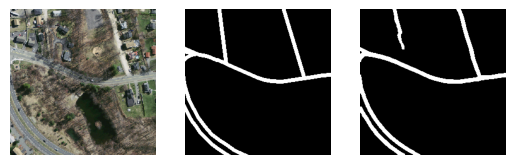

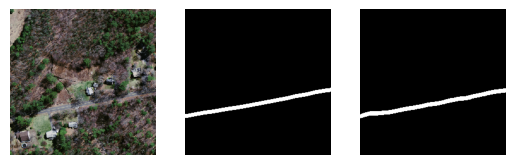

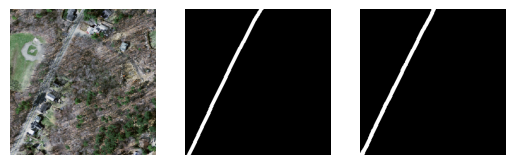

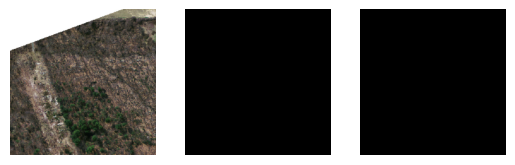

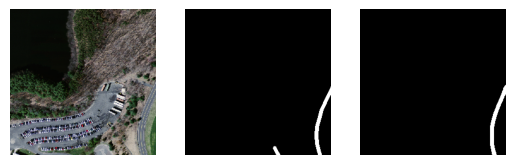

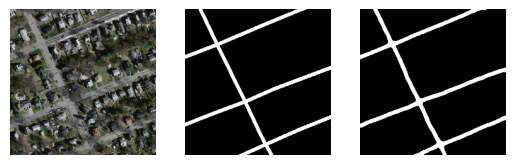

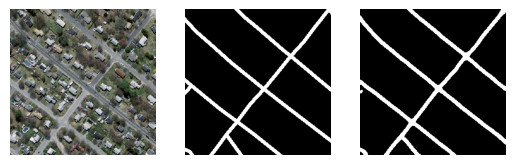

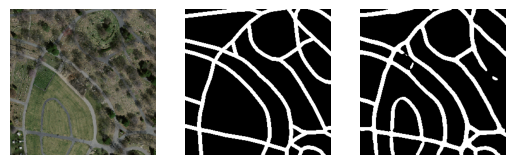

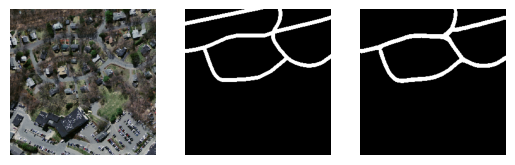

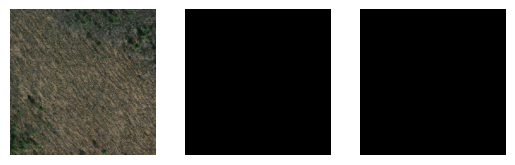

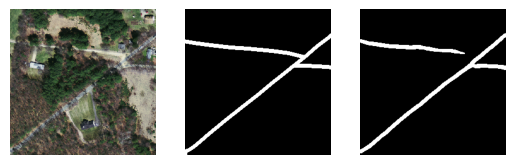

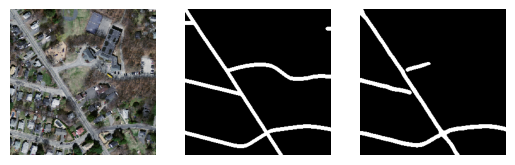

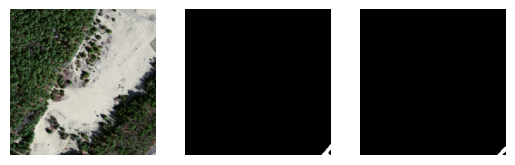

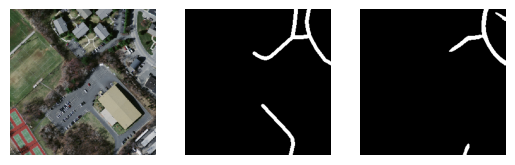

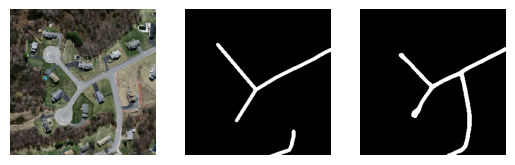

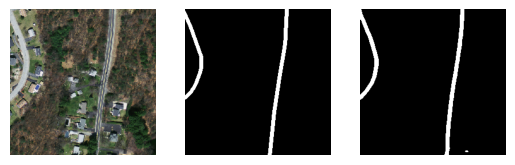

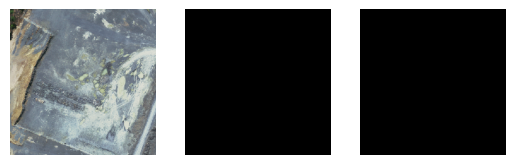

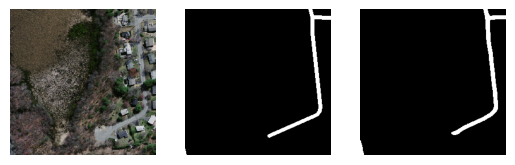

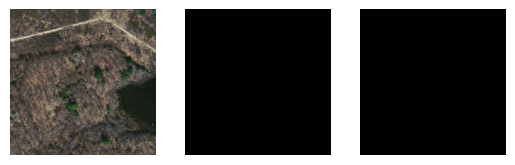

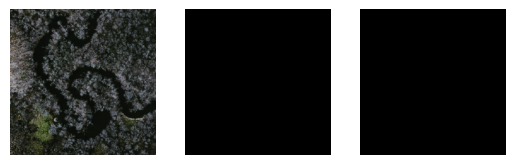

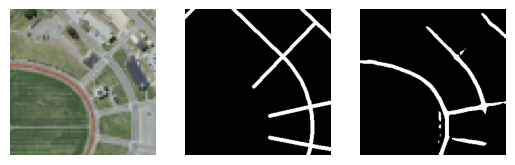

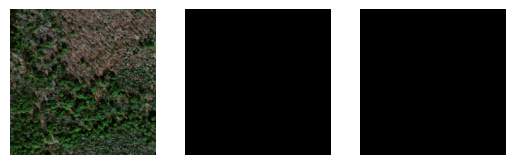

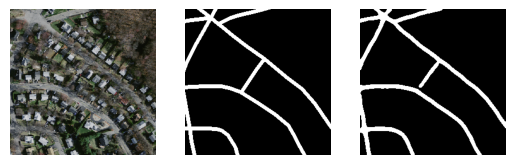

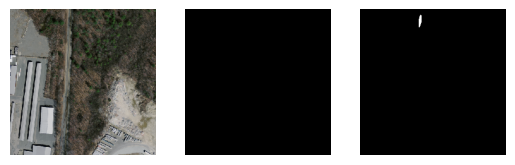

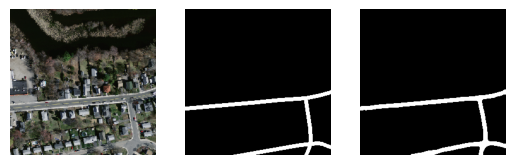

In [83]:
model = torch.load('best_model.pt', map_location=device)
for _ in range(25):
    random_idx = random.randint(0, len(visualize_dataset) - 1)
    image, mask = visualize_dataset[random_idx]
    image_for_predict = v2.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(image)
    
    predicted = predict(model, image_for_predict[None, ...])[0]
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.where(predicted > 0.5, 1., 0.)[0].cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.show()